<center>
    <h1>
Expectation-Maximisation algorithm – Importance sampling
    </h1>
</center>

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
import copy

# Discrete distributions.

Let $n \in N^*$ and $X=\{x_1,...,x_n\}$ a set of n distincs real numbers. Let $(p_i)_{i \in \{1,..,n\}}$ a sequence of real numbers such that:

$$\forall i \in \{1,..,n\}, \ \ p_i>0 \ \ \text{and} \ \ \sum_{i=1}^n p_i=1$$

## Question 1

Explain how to generate a random variable $X$ having the discrete distribution on $X$ given by
$(p_i)_{i \in \{1,..,n\}}$:
$$\forall i \in \{1,..,n\}, P(X=x_i)=p_i$$

We can use the fact that the distribution function of a random variable follows an uniform distribution on the interval $[0,1]$. With this in mind, it is enought to invert the distribution function and evaluate it at a point simulated from an uniform distribution.
In the discrete case this cn be done by using the following expression:

$$F^{-1}(u)=inf\{x \in \mathbb{R} | F(x) \geq u\}$$

## Question 2

Write (in Matlab, Python, Octave. . . ) the corresponding algorithm.

In [2]:
def r_discrete(n,p):

        ## Function performing simulations oa discrete distribution
        ## Input
        # n number of simulation
        # p vector of probabilities of the discrete distribution
        
        
        ## Output 
        # vector of simulations
        u=np.random.uniform(0,1,n)
        p_aux=np.concatenate([[0.0],np.cumsum(p,dtype=float)])
        sim=np.ones(n)
        for i in np.arange(0,n-1):
            index=np.where(p_aux<=u[i])[0]
            sim[i]=index[len(index)-1]
        return(sim)

## Question 3

Generate a sequence $(X_i)_{i \in {1,...,N}}$ of i.i.d. random variables having the same distribution as $X$ for
large values of $N$. Compare the empirical distribution to the theoretical distribution of $X$.

We can see in the figure, how after 1000 simulations, the sample distribution of the simulations is very close to the theoretical distribution.

In [3]:
n=1000
p=np.array([0.2,0.3,0.15,0.25,0.1])
simulations_p=r_discrete(n,p)

(array([0.197, 0.321, 0.144, 0.25 , 0.088]),
 array([0, 1, 2, 3, 4, 5]),
 <a list of 5 Patch objects>)

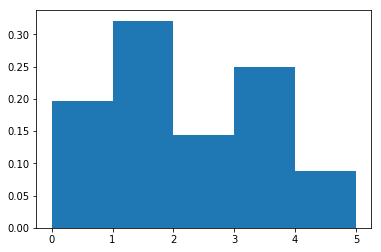

In [4]:
plt.hist(simulations_p,range(0,len(p)+1),density=True)

# Gaussian mixture model and the EM algorithm

A Gaussian mixture model (GMM) is useful for modelling data that comes from one of several groups: the groups might be different from each other, but data points within the same group can be wellmodelled by a Gaussian distribution. The main issue is to estimate the parameters of the mixture, i.e to find the most likely ones. Moreover, we aim to determine if our sample follow a Gaussian mixture distribution or not.
Let consider a n-sample. For each individual, we observe a random variable $X_i$ and assume there is an unobserved variable $Z_i$ for each person which encode the class of $X_i$. More formally, we consider a mixture of m Gaussian : let $(\alpha_1, . . . , \alpha_m) \in R^m+$ such that $\sum_{i=1}^m \alpha_i=1$ and the following hierarchical model :

$$\forall i \in \{1,...,n\}, \ \ \forall j \in \{1,...,m\} \ \ P_{\theta}(Z_i=j)=\alpha_j$$

and 

$$\forall i \in \{1,...,n\}, \ \ \forall j \in \{1,...,m\} \ \ X_i|\theta,\{Z_i=j\} \sim N(\mu_j,\Sigma_j)$$

Unless otherwise stated, we suppose that m is fixed.

## Question 1

Identify the parameters, denoted $\theta$, of the model and write down the likelihood of $\theta$ given the outcomes $(x_i)_{i \in \{1,...,n\}}$ of the i.i.d n-sample $(X_i)_{i \in \{1,...,n\}}$ i.e the p.d.f

$$L(x_1,...,x_n;\theta)=\prod_{i=1}^n f_{\theta}(x_i)$$

In this model $\theta=(\alpha_{1},\alpha_{2},...,\alpha_{K},\mu_{1},...,\mu_{K},\Sigma_{1},...,\Sigma_{K})$

$$\prod_{i=1}^{n} f_{\theta}(x_i)=\prod_{i=1}^{n} \sum_{j=1}^{m} f_{\theta}(x_i|z_i=j)p(z_i=j)=\prod_{i=1}^{n} \sum_{j=1}^{m} \alpha_{j}f_{N}(x_i,\mu_j,\Sigma_j)$$

where $f_{N}(x_i,\mu_j,\Sigma_j)$ is the density function of a multivariate normal distribution with parameters $\mu_j,\Sigma_j$.

In [5]:
def MixtureGaus_loglike(data,alpha,mu,sigma):
    ## Input
    # data=data set
    # alpha= proportion of each Gaussian.
    # mu= list with mean values
    # sigma= list with covariate matrices
    
    ## Output
    # loglike= loglikelihood of the observations
    aux_loglike=np.zeros((data.shape[0],len(alpha)))
    for j in np.arange(0,len(alpha)):
            aux_loglike[:,j]=alpha[j]*multivariate_normal.pdf(data,mu[j],sigma[j])
    aux_loglike=np.apply_along_axis(lambda x: np.log(np.sum(x)),1,aux_loglike)
    loglike=np.sum(aux_loglike)
    return(loglike)

## Question 2

Sample a set of observation according to a Gaussian mixture law, with the parameters of your
choice. Use the hierarchical model and the first exercise.

In [6]:
def sim_MixtureGaus(N,alpha,mu,sigma):
    ## Function to simulate observations from a Gaussian mixture model.
    ## Input
    # N= number of simulations
    # alpha= proportion of each Gaussian.
    # mu= list with mean values
    # sigma= list with covariate matrices
    
    ## Output
    # sim= simulations of the Gaussian mixture
    # label= cluster from the observations was sampled
    
    y=r_discrete(N,alpha)
    sim=np.zeros(N*len(mu[0]))
    sim.shape=(N,len(mu[0]))
    n_iter=0
    label=np.array([])
    for i in np.unique(y):
        n_i=np.sum(y==i)
        sim[n_iter:(n_iter+n_i),:]=np.random.multivariate_normal(mu[int(i)],sigma[int(i)],n_i)
        n_iter=n_iter+n_i 
        label=np.concatenate((label,np.repeat(i,n_i)))
    label=[i for i in label]
    return(dict(sim=sim,label=np.array(label)))

I fix the values of the Gaussian mixture to be simulated.

In [7]:
N=1000
mu=[np.array([0,0]),np.array([-3,-3]),np.array([3,3])]
sigma1=np.identity(2)
sigma2=np.array([1,0.8,0.8,1])
sigma2.shape=(2,2)
sigma3=np.array([1,-0.5,-0.5,1])
sigma3.shape=(2,2)
sigma=[sigma1,sigma2,sigma3]
alpha=np.array([0.3,0.2,0.5])

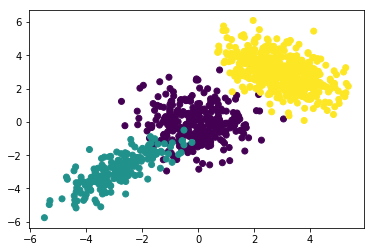

In [8]:
results=sim_MixtureGaus(N,alpha,mu,sigma)
plt.scatter(results["sim"][:,0],results["sim"][:,1],c=results["label"])

# Question 3

Implement the EM algorithm in order to estimate the parameters of this model from your observations
and plot the log-likelihood over the number of iteration of the algorithm.

In [9]:
def EM_gaussian_E_step(data,alpha,mu,sigma):
    ### Function that computes the E-step of the EM algorithm
    
    ## Input
    # data: data set 
    # alpha= proportion of each Gaussian.
    # mu= list with mean values
    # sigma= list with covariate matrices
    
    ## Output:
    ## Tau: matrix with the probabilities P(z=j|x,tetha)
    tau=np.zeros((data.shape[0],len(alpha)))
    for j in np.arange(0,len(alpha)):
            tau[:,j]=alpha[j]*multivariate_normal.pdf(data,mu[j],sigma[j])
    denominator=np.apply_along_axis(np.sum,1,tau)
    for j in np.arange(0,len(alpha)):
        tau[:,j]=tau[:,j]/denominator
    return(tau)
    
def EM_gaussian_M_step(data,tau):
    ## Function that computes the M-step value of the EM algorithm
    
    ## Input
    # data=data set
    # tau: matrix with the probabilities P(z=j|x,tetha)
    
    ## Output
    # alpha= proportion of each Gaussian.
    # mu= list with mean values
    # sigma= list with covariate matrices

    sigma=[]
    mu=[]
    alpha=np.zeros(tau.shape[1])
    for j in np.arange(0,tau.shape[1]):
        alpha[j]=np.mean(tau[:,j])
        mu.append(np.apply_along_axis(lambda x: np.average(x,weights=tau[:,j]),0,data))
        
        W=np.identity(data.shape[0])
        np.fill_diagonal(W,tau[:,j])
        data_centered=data-mu[j]
        sigma.append((np.transpose(data_centered).dot(W).dot(data_centered))/np.sum(tau[:,j]))
    return(dict(alpha=alpha,mu=mu,sigma=sigma))

def EM_gaussian(data,max_iter=100,k=2):
    ## Function that performs the EM algorithm
    
    ## Input
    # data=data set 
    # max iter= maximum number of iteractions.
    ## k= number of clusters to find
    
    ## Output
    # alpha= proportion of each Gaussian.
    # mu= list with mean values
    # sigma= list with covariate matrices
    # tau: matrix with the probabilities P(z=j|x,tetha)
    # loglike= sequence of loglikehood.
    
    ### K means initialization
    kmeans=KMeans(n_clusters=k).fit(data)
    labels=kmeans.labels_
    
    loglike_seq=np.zeros(max_iter+1)
    mu=[]
    sigma=[]
    alpha=np.zeros(k)
    for i in np.arange(0,k):
        index=np.where(labels==i)[0]
        mu.append(np.apply_along_axis(np.mean,0,data[index,:]))
        sigma.append(np.cov(data[index,0],data[index,1]))
        alpha[i]=len(index)/data.shape[0]
    n_iter=0
    loglike_seq[n_iter]=MixtureGaus_loglike(data,alpha,mu,sigma)
    
    while(n_iter<max_iter):
        ## E-step
        tau=EM_gaussian_E_step(data,alpha,mu,sigma)
        ## M-step
        results=EM_gaussian_M_step(data,tau)
        mu=results["mu"]
        alpha=results["alpha"]
        sigma=results["sigma"]
        n_iter=n_iter+1
        loglike_seq[n_iter]=MixtureGaus_loglike(data,alpha,mu,sigma)
    return(dict(alpha=alpha,mu=mu,sigma=sigma,tau=tau,loglike=loglike_seq))

In [10]:
data=results["sim"]
max_iter=100
results_EM=EM_gaussian(data,max_iter,k=3)

As theory says, the loglikelihood is nondecreasing respect with the number of intractions. 

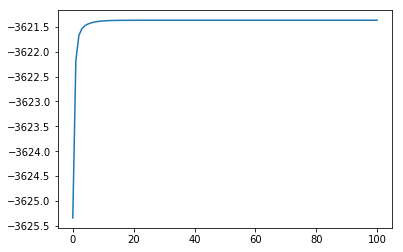

In [11]:
plt.plot(np.arange(0,max_iter+1),results_EM["loglike"])

# Question 4

The parameters are close to the original ones. But it is a result that depends on the number of observations and the overlap of the clusters.

In [12]:
print(alpha)
print(results_EM["alpha"])

[0.3 0.2 0.5]
[0.51216787 0.19776756 0.29006457]


In [13]:
print(mu)
print(results_EM["mu"])

[array([0, 0]), array([-3, -3]), array([3, 3])]
[array([2.97556582, 2.98207602]), array([-2.87404145, -2.89809061]), array([-0.07201629, -0.09469628])]


In [14]:
print(sigma)
print(results_EM["sigma"])

[array([[1., 0.],
       [0., 1.]]), array([[1. , 0.8],
       [0.8, 1. ]]), array([[ 1. , -0.5],
       [-0.5,  1. ]])]
[array([[ 0.9634959 , -0.46725485],
       [-0.46725485,  0.947167  ]]), array([[1.00144666, 0.80723205],
       [0.80723205, 1.01887895]]), array([[0.96657982, 0.02116027],
       [0.02116027, 1.15984257]])]


# Question 5

Download the data Crude Birth/Death Rate – See esa.un.org/unpd/wpp/ - for
instance and plot the associated scatter graph. What do you think about using a Gaussian
mixture model ?

The idea of fitting a mixture Gaussian seems to be pertinent in this case. From the context of the data, we expect that data points are clustered by the level of development of each country. Additionally, the figure does not indicate that the dispertion of the data can be modeled by just a Gaussian.

In [15]:
data=np.array(pd.read_csv("BirthvsDeath.csv"))

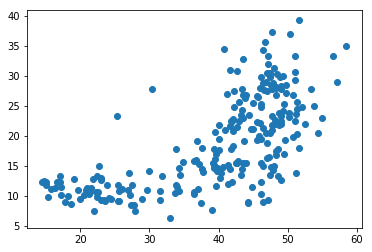

In [16]:
plt.scatter(data[:,0],data[:,1])

# Question 6

Estimate the parameters $\theta$ for different values of m, try to interpret them and compute the BIC.
Plot the corresponding p.d.f over the scatter plot.

I fitted four different models on the data set. The figures show the clusters estimated by each model, as well as the contour of each Gaussian component. From the figures, it seems that k=2 and k=3 described better the data points.
It is interesting to note how,as we increase the number of parameters, the loglikehood increases too. 

In [17]:
def plot_cluster_EM_gaussian(data,y,mu,sigma,k=4):
    ## Function to draw the Gaussian contour at 90%.
   
    ## Input
    # data=data set 
    # max iter= maximum number of iteractions.
    # y= label of the data
    # mu= list with mean values
    # sigma= list with covariate matrices
    # k= number of clusters to find

    plt.figure()
    plt.scatter(data[:,0],data[:,1],c=y)
    s=4.6057
    
    for j in np.arange(0,k):   
        [V, D] = np.linalg.eig(sigma[j] * s)
        t = np.linspace(0,2*np.pi)
        vec = np.array([np.cos(t),np.sin(t)])
        VD = D@np.sqrt(np.diag(V))
        z=VD@vec+mu[j].reshape(-1,1)
        plt.plot(z[0,:],z[1,:])

In [18]:
EM_1=EM_gaussian(data,max_iter=100,k=1)
print(EM_1["mu"])
print(EM_1["sigma"])
print(EM_1["loglike"][99])

[array([39.41950207, 18.74979253])]
[array([[118.11725452,  55.9039667 ],
       [ 55.9039667 ,  57.56797714]])]
-1673.1342284219236


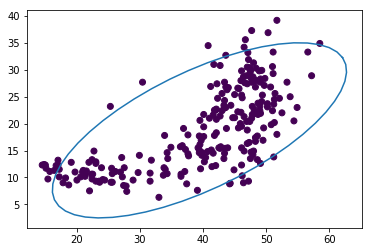

In [19]:
label_1=np.apply_along_axis(np.argmax,1,EM_1["tau"])
plot_cluster_EM_gaussian(data,label_1,mu=EM_1["mu"],sigma=EM_1["sigma"],k=1)

In [20]:
EM_2=EM_gaussian(data,max_iter=100,k=2)
print(EM_2["mu"])
print(EM_2["sigma"])
print(EM_2["loglike"][99])

[array([22.82058482, 10.81775367]), array([44.85906667, 21.34916917])]
[array([[26.07576068, -1.42425793],
       [-1.42425793,  2.56290086]]), array([[28.40005766, 17.40445438],
       [17.40445438, 48.21835465]])]
-1567.155426042686


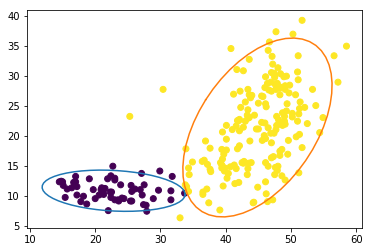

In [21]:
label_2=np.apply_along_axis(np.argmax,1,EM_2["tau"])
plot_cluster_EM_gaussian(data,label_2,mu=EM_2["mu"],sigma=EM_2["sigma"],k=2)

In [22]:
EM_3=EM_gaussian(data,max_iter=100,k=3)
print(EM_3["mu"])
print(EM_3["sigma"])
print(EM_3["loglike"][99])

[array([22.07474748, 10.71920534]), array([39.45178903, 14.46592279]), array([47.08461475, 24.46479023])]
[array([[20.16534312, -2.23340141],
       [-2.23340141,  2.46273904]]), array([[29.57178019, -1.39292391],
       [-1.39292391, 14.71772786]]), array([[14.12637643,  5.09899974],
       [ 5.09899974, 33.09472956]])]
-1553.8512035110984


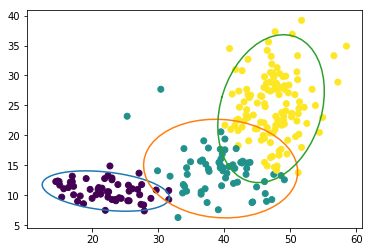

In [23]:
label_3=np.apply_along_axis(np.argmax,1,EM_3["tau"])
plot_cluster_EM_gaussian(data,label_3,mu=EM_3["mu"],sigma=EM_3["sigma"],k=3)

In [24]:
EM_4=EM_gaussian(data,max_iter=100,k=4)
print(EM_4["mu"])
print(EM_4["sigma"])
print(EM_4["loglike"][99])

[array([22.10565888, 10.72435936]), array([46.97995658, 24.82512089]), array([47.35247536, 23.73263077]), array([39.68236828, 14.59416311])]
[array([[20.349184  , -2.20650313],
       [-2.20650313,  2.47456006]]), array([[ 9.6786625 ,  0.58864565],
       [ 0.58864565, 31.04764021]]), array([[27.91621641, 19.24711498],
       [19.24711498, 37.74325021]]), array([[29.21497655, -1.3355027 ],
       [-1.3355027 , 15.09559128]])]
-1552.342204843802


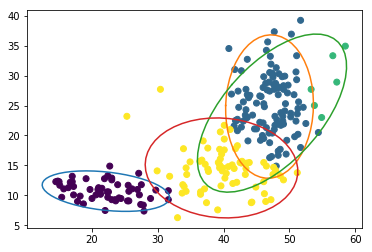

In [25]:
label_4=np.apply_along_axis(np.argmax,1,EM_4["tau"])
plot_cluster_EM_gaussian(data,label_4,mu=EM_4["mu"],sigma=EM_4["sigma"],k=4)

The BIC criteria is useful to rank different models by taking into account how well the model fits the data and the number of parameters. The BIC criteria penalizes models with more parameters. In this case, the BIC suggests that the model with 2 components is the best one followed closely by the models with 3 components. From the figures and the BIC criteria I would choose the model with three components.

In [26]:
df1=len(EM_1["alpha"])*(1+2+3)-1
BIC_1=-EM_1["loglike"][99]+((df1)*np.log(data.shape[0]))/2
print(BIC_1)

1686.8462207556502


In [27]:
df2=len(EM_2["alpha"])*(1+2+3)-1
BIC_2=-1.*EM_2["loglike"][99]+((df2)*np.log(data.shape[0]))/2
print(BIC_2)

1597.3218091768847


In [28]:
df3=len(EM_3["alpha"])*(1+2+3)-1
BIC_3=-EM_3["loglike"][99]+((df3)*np.log(data.shape[0]))/2
print(BIC_3)

1600.471977445769


In [29]:
df4=len(EM_4["alpha"])*(1+2+3)-1
BIC_4=-1.*EM_4["loglike"][99]+((df4)*np.log(data.shape[0]))/2
print(BIC_4)

1615.4173695789445


# Exercise 3: Importance sampling

Let $p$ be a density on $\mathbb{R}^d, d \in \mathbb{N}^*$. Importance Sampling aims at evaluating.

$$ E_p[g(X)]=\int g(x)p(x)dx$$

Classical Monte Carlo integration requires to generate iid random variables $(X_1,..,X_n)$ from $p$ in order to approximate $E_p[g(X)]$ by $\frac{1}{n}\sum_{i=1}^n g(X_i)$. Sampling from other distributions than the original
distribution $p$ can improve the variance of the estimator and reduce the number of samples needed.

Importance sampling is based on the following fundamental equality

$$E_p[g(X)]=\int g(x)p(x)dx = \int g(x) \frac{p(x)}{q(x)}q(x)dx=E_q[g(X)\frac{p(X)}{q(X)}]$$

which hold for any density $q$ such that $Supp(g × p) \subset Supp(q)$. The density $q$ is called importance
density. If $(X_1, . . . ,X_n)$ is a sample from $q$, $E_p [g(X)]$ can therefore be approximated by

$$\frac{1}{n}\sum_{i=1}^n \frac{p(X_i)}{q(X_i)} g(X_i)=\frac{1}{n} \sum_{i=1}^n w_i g(X_i) \ \text{with} \  w_i=\frac{p(X_i)}{q(X_i)}$$

The $(w_i)_i$ are called importance weights. In Bayesian inference, the density $p$ might be known only up
to a normalizing constant. In this case, $E_p [g(X)]$ can be approximated by

$$\sum_{i=1}^n \hat{w}_i g(X_i) \ \text{where} \ \hat{w}_i=\frac{w_i}{\sum_{j=1}^N w_i}$$

Then $(\hat{w}_i)_i$ are called normalized importance weights and do not depend on the normalizing constant of $p$.

## 3.A Poor Importance Sampling.

The performance of Importance Sampling depends on the choice of importance density (or importance
function). The "best" importance density $q^*$ is chosen among a parametric family of densities $Q$. Given a density $q$ on $\mathbb{R}^d$, the approximation is measured in terms of the Kullback-Leibler divergence $K(p||q)$ given by

$$K(p || q) =\int log(\frac{p(x)}{q(x)})p(x) dx$$

therefore

$$q^*=argmin_{q \in Q} K(p||q)$$

The parametric family $Q$ of of distributions on $\mathbb{R}^d$ should be chosen large enough to allow for a close match with $p$ and be such that the optimization problem  is feasible. Before studying the above optimisation problem, we will illustrate the importance of choosing carefully the distribution $q$ and explore the effects of selecting a poor distribution to cover $p$.

In this section, we will implement importance sampling in order to calculate the expectation of a function $f$ defined by

$$f(x)=2sin(\frac{\pi}{1.5}x) \mathbb{1}_{\mathbb{R}^+}(x)$$

where x is distributed according to a distribution similar to a $\chi$ distribution. We will use a scaled normal distribution $N(0.8, 1.5)$ as our sampling distribution where the parameters are chosen so that
$p(x) < k q(x)$ for all $x \in \mathbb{R}^+$ where $k \in \mathbb{R}^+$. Let consider

$$p(x)=x^{(1.65)-1} e^{\frac{-x^2}{2}} \mathbb{1}_{\mathbb{R}^+}(x) \ \ \ \text{and} \ \ \ q(x)=\frac{1}{\sqrt{2\pi(1.5)}} e^{-\frac{(x-0.8)^2}{2(1.5)}}$$


Mainly, neither $p$ nor $q$ are proper distributions here without normalization.


## Question 1


Implement a simple importance scheme for the previous functions.
Be careful when sampling from $q$ supported on $\mathbb{R}$ to discard any samples $x < 0$ while $p$ is supported
only for $x > 0$.

In [30]:
def f(x):
    return np.where(x>0,2.*np.sin(np.pi/1.5*x),0)
def p(x):
    return np.where(x>0,x**(0.65)*np.exp(-x**2/2.),0)
def q(x,mu,sigma):
    return (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-1*(x-mu)**2/(2*sigma**2))
def importance_sampling(N,mu,sigma):
    aux=np.random.normal(size=2*N,loc=mu,scale=sigma**2)
    sim=aux[aux>0]
    len_=len(sim)
    while len_<N:
        aux=np.random.normal(size=2*(N-len_),loc=mu,scale=sigma**2)
        sim=np.concatenate([sim,aux[aux>0]])
        len_=len(sim)
    
    w=p(sim[:N])/q(sim[:N],mu,sigma)
    return(np.mean(w*f(sim[:N])))

## Question 2

Compare the estimate and the importance weight for several sample size, $N = 10, 100, 10^3, 10^4$
for instance.

In [31]:
res_10=[]
res_100=[]
res_1000=[]
res_10000=[]
for i in range(1000):
    res_10.append(importance_sampling(10,0.8,1.5))
    res_100.append(importance_sampling(100,0.8,1.5))
    res_1000.append(importance_sampling(1000,0.8,1.5))
    res_10000.append(importance_sampling(10000,0.8,1.5))

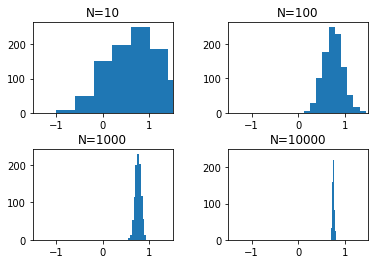

In [32]:
plt.subplot(2, 2, 1)
plt.hist(res_10)
plt.title('N=10')
plt.xlim(-1.5,1.5)
plt.subplot(2, 2, 2)
plt.hist(res_100)
plt.title('N=100')
plt.xlim(-1.5,1.5)
plt.subplot(2, 2, 3)
plt.hist(res_1000)
plt.title('N=1000')
plt.xlim(-1.5,1.5)
plt.subplot(2, 2, 4)
plt.hist(res_10000)
plt.title('N=10000')
plt.xlim(-1.5,1.5)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

In [33]:
print(sum(res_10)/len(res_10))
print(sum(res_100)/len(res_100))
print(sum(res_1000)/len(res_1000))
print(sum(res_10000)/len(res_10000))

0.7561810626311906
0.7557792948808847
0.759270233658586
0.7577874392803077


## Question 3

Shift the mean of $q, \mu = 6$, so that the centers of mass for each distribution are far apart and repeat the experiment.

In [34]:
res_10=[]
res_100=[]
res_1000=[]
res_10000=[]
for i in range(1000):
    res_10.append(importance_sampling(10,6.,1.5))
    res_100.append(importance_sampling(100,6.,1.5))
    res_1000.append(importance_sampling(1000,6.,1.5))
    res_10000.append(importance_sampling(10000,6.,1.5))

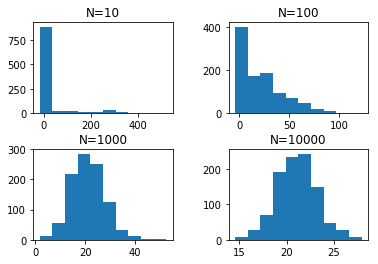

In [35]:
plt.subplot(2, 2, 1)
plt.hist(res_10)
plt.title('N=10')
#plt.xlim(-1.5,1.5)
plt.subplot(2, 2, 2)
plt.hist(res_100)
plt.title('N=100')
#plt.xlim(-1.5,1.5)
plt.subplot(2, 2, 3)
plt.hist(res_1000)
plt.title('N=1000')
#plt.xlim(-1.5,1.5)
plt.subplot(2, 2, 4)
plt.hist(res_10000)
plt.title('N=10000')
#plt.xlim(-1.5,1.5)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

I stimated the value of the integral by using the numerical methods proposed by python. 

In [36]:
import scipy.integrate as integrate
result = integrate.quad(lambda x: f(x)*p(x), 0, np.Inf)

In [37]:
result

(0.7752953044208203, 5.888112378347464e-09)

The error made by shifting the mean of the auxiliar distribution is large and it does not reduce even if we increase the size of the sample.

In [39]:
print(sum(res_10)/len(res_10))
print(sum(res_100)/len(res_100))
print(sum(res_1000)/len(res_1000))
print(sum(res_10000)/len(res_10000))

20.79577276813182
20.428031559190913
21.102089821623586
21.070464305143375


## 3.B Adaptative Importance Sampling

In the following, we choose $Q$ to be the family of mixtures of $M$ Gaussian distributions on $\mathbb{R}^d$. An
element of $q \in Q$ is of the form:
$$ q(x)=\sum_{i=1}^M \alpha_i \psi(x,\mu_i,\Sigma_i)$$

where, for all $i$, $\alpha_i > 0$,$\sum_{i=1}^M \alpha_i= 1$ and $(\mu_i,\Sigma_i)$ are mean and covariance parameters which parametrize
the i-th Gaussian component of $q$. Because the family $Q$ is a parametric family of distributions, the optimization problem can be written:

$$\theta=argmax \int log(\sum_{i=1}^M \alpha_i \psi(x,\mu_i,\Sigma_i)) p(x)dx$$

The solution cannot always be obtained in closed-form due to the density $p$ which makes the exact computation impossible. The Population Monte Carlo is an algorithm which aims at approximating this solution $q_\theta$ .

## Question 4

Explain how the EM algorithm can be used to maximize the empirical criterion in step (iii).
Derive the parameters update.



The Population Monte Carlo algorithm iterates between the following steps :

(i) Choose mixture parameters $(\alpha^{(0)}, \mu^{(0)},\Sigma^{(0)})$. This choice of parameters defines an importance density $q(0)$ as follows :
$$q^{(0)}(x)=\sum_{i=1}^M \alpha^{(0)}_i \psi(x,\mu_i^{(0)},\Sigma_i^{(0)})$$

(ii) This importance density is used to compute an Importance Sampling estimate of the
quantity of interest. Let $(X_1, . . . ,X_n)$ be i.i.d. random variables generated from $q^{(0)}$.
The exact criterion is approximated using normalized importance weights :
$$\sum_{i=1}^n\sum_{j=1}^M \hat{w}_i log(\alpha_j \psi(x_i,\mu_j,\Sigma_j))$$
(iii) New parameters $(\alpha^{(1)}, \mu^{(1)},\Sigma^{(1)})$ are obtained by maximizing
$$\sum_{i=1}^n\sum_{j=1}^M \hat{w}_i log(\alpha_j \psi(x_i,\mu_j,\Sigma_j))$$
with respect to $\alpha, \mu \Sigma$. The new parameters define a density $q^{(1)}$.

(iv) We start again with steps from (i) to (iii) until convergence.

## 3.C Application to a "banana"-shaped density

The target density is based on a Gaussian distribution in $\mathbb{R}^d$ with mean 0 and covariance matrix
$\Sigma = diag(\sigma_1,1, 1, . . . , 1)$. This density defined on $\mathbb{R}^d$ is twisted by changing the second coordinate $x_2$ to

$x_2 + b(x_1^2− \sigma_1^2)$. If $\phi(·; \mu, \Sigma)$ denotes the density function of the d-dimensional Gaussian with mean $\mu$ and covariance $\Sigma$, we have :
$$ \forall x = (x_1, . . . , x_d) \in \mathbb{R}^d$$
$$p(x) = \phi(x_1,x_2+b(x_1^2− \sigma_1^2),x_3,...,x_d)$$
If we choose $d = 10$, $\sigma^2_1 = 100$ and $b = 0.03$, $p$ results in a banana-shaped density in the first two dimensions.

## Question 5 

Using the Adaptive Importance Sampling, write an algorithm which allows to exploring the density
p. You may display the results for the banana-shaped density in the first two coordinates.

In [66]:
def sim_banana(size,sigma,d,b):
    Sigma=np.array([np.array(sigma**2)]+((d-1)*[1]))
    Sigma=Sigma*np.eye(d)
    sim=np.random.multivariate_normal(np.zeros(d),cov=Sigma,size=size)
    sim[:,1]=sim[:,1]+b*(sim[:,0]**2-sigma**2)
    return sim

In [67]:
sim_banana_=sim_banana(10000,sigma=10,d=4,b=0.03)

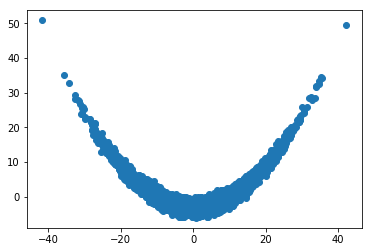

In [68]:
plt.scatter(sim_banana_[:,0],sim_banana_[:,1])

In [69]:
def Banana_density(data,sigma,d,b):
    ##### Function computing the density of the Banana distribution
    ## Input
    # data=data set
    # sigma= variance of the first variable
    # d= dimension of the random vector
    # b= parameter modeling the response of the second variable 
    
    ## Output
    # like= likelihood of the observations 
    Sigma=np.array([np.array(sigma**2)]+((d-1)*[1]))
    Sigma=Sigma*np.eye(d)
    aux_data=copy.deepcopy(data)
    aux_data[:,1]=aux_data[:,1]+b*(aux_data[:,0]**2-sigma**2)
    return multivariate_normal.pdf(aux_data,np.zeros(d),Sigma)

In [70]:
def MixtureGaus_density(data,alpha,mu,sigma):
    ### Function computing the density of a Gaussian Mixture 
    ## Input
    # data=data set
    # alpha= proportion of each Gaussian.
    # mu= list with mean values
    # sigma= list with covariate matrices
    
    ## Output
    # like= likelihood of the observations
    aux_loglike=np.zeros((data.shape[0],len(alpha)))
    for j in np.arange(0,len(alpha)):
            aux_loglike[:,j]=alpha[j]*multivariate_normal.pdf(data,mu[j],sigma[j])
    density=np.sum(aux_loglike,axis=1)
    return(density)

In [71]:
def weight(data,alpha,mu,sigma,sigma_1,d,b):
    ##### Function computing the weights of the importance sampling method 
    ## Input
    #### Gaussian Mixture parameters
    # data=data set
    # alpha= proportion of each Gaussian.
    # mu= list with mean values
    # sigma= list with covariate matrices
    #### Banana parameters 
    # sigma= variance of the first variable
    # d= dimension of the random vector
    # b= parameter modeling the response of the second variable 
    
    ### Outpu
    # log_w= logarithm of the weights 
    # normalized weights
    log_w=np.log(Banana_density(data,sigma_1,d,b))-np.log(MixtureGaus_density(data,alpha,mu,sigma))
    
    return log_w,np.exp(log_w)/np.sum(np.exp(log_w))

In [86]:
def Importance_Sampling_EM(sigma,d,b,tol=1e-6,max_iter=100,max_iner_iter=10,k=2):
    ## Function that performs the EM algorithm
    
    ## Input
    # data=data set 
    # max iter= maximum number of iteractions.
    ## k= number of clusters to find
    
    ## Output
    # alpha= proportion of each Gaussian.
    # mu= list with mean values
    # sigma= list with covariate matrices
    # tau: matrix with the probabilities P(z=j|x,tetha)
    # loglike= sequence of loglikehood.

    
    sigma=k*[np.random.uniform(5,size=1)*np.eye(d)]
    mu=[np.random.uniform(size=d) for x in range(k)]
   
    alpha=np.ones(k)/k
    n_iter=0
    KL=np.inf
    simulations=sim_MixtureGaus(10000,alpha,mu,sigma)["sim"]
    while(max_iter>n_iter):
        iner_iter=0
        log_w,w=weight(simulations,alpha,mu,sigma,sigma_1,d,b)
        
        loglike_seq=[-1.*np.Inf]
        loglike_seq.append(MixtureGaus_loglike(simulations,alpha,mu,sigma))
        ##### EM Optimization
        while(loglike_seq[len(loglike_seq)-1]-loglike_seq[len(loglike_seq)-2]>tol and max_iner_iter>iner_iter):
        
        ## E-step
            tau=EM_gaussian_E_step(simulations,alpha,mu,sigma)
    
        ## M-step
            results=EM_gaussian_M_step_mod(simulations,tau,w)
            mu=results["mu"]
            alpha=results["alpha"]
            sigma=results["sigma"]
            
            loglike_seq.append(MixtureGaus_loglike(simulations,alpha,mu,sigma))
            print(loglike_seq[len(loglike_seq)-1])
            iner_iter+=1
           
        simulations=sim_MixtureGaus(10000,alpha,mu,sigma)["sim"]
        KL=np.sum(log_w*Banana_density(simulations,sigma_1,d,b))
        print(KL)
        n_iter+=1
        
    return alpha,mu,sigma,tau

In [87]:
def EM_gaussian_M_step_mod(data,tau,w):
    ## Funtion that computes the M-step value of the EM algorithm
    
    ## Input
    # data=data set
    # tau: matrix with the probabilities P(z=j|x,tetha)
    # ww: weights given by the importance-sampling estimator 
    
    ## Output
    # alpha= proportion of each Gaussian.
    # mu= list with mean values
    # sigma= list with covariate matrices

    sigma=[]
    mu=[]
    alpha=np.zeros(tau.shape[1])
    for j in np.arange(0,tau.shape[1]):
        alpha[j]=np.sum(tau[:,j]*w)
        mu.append(np.average(data,weights=tau[:,j]*w,axis=0))

        data_centered=data-mu[j]
        aux_sigma=0
        for i in range(data.shape[0]):
            aux_sigma+=tau[i,j]*w[i]*np.outer(data_centered[i],data_centered[i])
        aux_sigma=aux_sigma/np.sum(tau[:,j]*w)
        sigma.append(aux_sigma)
    alpha=alpha/np.sum(alpha)
    return(dict(alpha=alpha,mu=mu,sigma=sigma))

In [88]:
sigma_1=10.
d=4
b=0.03
k=50
tol=1e-2
max_iter=30
iner_iter=10
alpha,mu,sigma,tau=Importance_Sampling_EM(sigma_1,d,b,tol=tol,max_iter=max_iter,max_iner_iter=iner_iter,k=k)

-126316.39702157429
-48.36688917723551
-73270.25663665326
-4.864715721157382
-76739.90331241618
-4.919513946876654
-79619.42785245071
-4.215754357754729
-80576.70385601182
-2.9652209586907547
-80729.28199818067
-2.004181418656445
-81334.9814616346
-1.482741046821959
-80957.73520708179
-0.9682648907838711
-80205.99765599203
-0.6824808413606497
-80276.28935444517
-0.5072477551407513
-80823.44508203195
-0.5038427579367868
-80271.5039581836
-80289.04678177446
-0.351715481988585
-80059.27347578015
-80062.7335344619
-0.3080348765697576
-79811.13720347881
-79815.4877052257
-0.1620174688437272
-79871.75523760534
-0.10472163416225284
-80354.82655342894
-0.26055410844348265
-80053.63081211995
-80054.25910626024
-0.14558154862095585
-80005.04026434913
-0.06919469717841538
-80040.55736315585
-0.06801217182778627
-79994.27002044115
-0.05531141633886745
-79961.77515867079
-79959.49837770262
-79960.57079657222
-0.05261116992303158
-80046.22568995017
-0.10867126926474718
-79714.68539780389
-79715.5117

The proposed algorithm is very effective to generate the desired distribution 

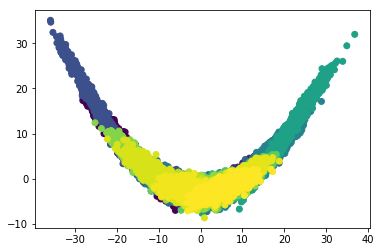

In [89]:
results=sim_MixtureGaus(100000,alpha,mu,sigma)
plt.scatter(results["sim"][:,0],-1*results["sim"][:,1],c=results["label"])